In [1]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.rnn_optimizer import kl_divergence
from utils.utils import Experiment, get_model, create_def_argparser, get_experiment, create_logger
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, create_x_val_array, plot_kl_div_parts
from utils.plots import get_exper_loss_data, plot_loss_over_tsteps, plot_exper_losses, plot_parm_loss_steps
from utils.plots import plot_qt_mode_hist, plot_qt_detailed_stats
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction, L2LQuadratic, neg_log_likelihood_loss

%load_ext autoreload
%autoreload 2

In [2]:
expers_to_load = [# Meta V1 model regression
                  (True, "run_20170702_15_29_52_metaV1_40ep_100ops_retrain_lr5e06_adam"), # 110 epo
                  (False, "run_20170706_00_19_55_metaV3_80ep_100ops_lr5e05_adam"), # no fixed weights
                  # Meta V3 model regression with fixed geometric weights 
                  (False, "run_20170707_13_00_41_metaV3_20ep_100ops_retrain_lr5e06_adam"), # nu=0.1, 30 epochs
                  (False, "run_20170707_19_18_08_metaV3_30ep_100ops_lr5e05_adam"), # 0.5, 30 epochs
                  (False, "run_20170706_09_48_03_metaV3_80ep_100ops_lr5e05_adam"), # nu=0.98, 80 epochs
                  # ACT V2 model (1 LSTM)
                  (True, "run_20170706_17_38_38_actV2_100ep_100ops_lr5e06_adam"), # nu=0.1 100 epochs
                  (True, "run_20170707_08_57_39_actV2_40ep_100ops_retrain_lr5e06_adam"), # nu=0.3, 100 epochs
                  (True, "run_20170701_18_28_48_actV2_50ep_100ops_retrain_lr5e06_adam"), # 0.5 100 epo
                  (True, "run_20170702_20_43_33_actV2_40ep_100ops_retrain_lr5e06_adam"), # 0.7 70+40epo
                  (False, "run_20170702_17_08_24_actV2_40ep_100ops_retrain_lr5e06_adam"),  # 0.80 / lr5e-6 / 110 eps
                  (False, "run_20170703_18_05_47_actV2_40ep_100ops_retrain_lr5e06_adam"), # q=0.90 / lr 1e-6 / 70eps
                  (True, "run_20170702_13_56_09_actV2_20ep_100ops_retrain_lr5e06_adam"), # 0.98 / lr5e-6 / 120eps
                  (False, "run_20170703_15_19_53_actV2_80ep_21ops_lr5e06_adam"), # 0.93 stochastic 80epos
                  (False, "run_20170702_20_51_12_actV2_150ep_49ops_lr5e06_adam"), # 0.98 stochastic 
                  # ACT V1 model (2 LSTM cells per layer)
                  (False, "run_20170708_14_41_22_actV1_80ep_21ops_lr5e05_adam"), # nu=0.1, 80 epochs
                  (False, "run_20170708_11_19_46_actV1_20ep_21ops_retrain_lr2e05_adam"), # nu=0.2, 80epochs
                  (False, "run_20170708_06_28_36_actV1_20ep_21ops_retrain_lr5e06_adam"), # nu=0.3, 120epo
                  (False, "run_20170707_11_00_09_actV1_20ep_21ops_retrain_lr5e06_adam")] # nu=0.93, 100epo




In [3]:
without_models = False

experiments = []
models = []
new_experiments = []
explogger = None
m = 0
for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        exp = get_experiment(exp_path[1])
        if "act" in exp.args.model:
            print("{} Loading model {} (q-prob {:.2f}) / {}".format(m, exp.args.model, 
                                                                    exp.config.ptT_shape_param,
                                                                    exp.args.log_dir))
        else:
            print("{} Loading model {} / {}".format(m, exp.args.model, exp.args.log_dir))
        
        experiments.append(exp)
        if explogger is None:
            explogger = create_logger(exp, file_handler=False)
        m += 1
        if not without_models:
            models.append(get_model(exp, exp.args.x_dim, retrain=True, logger=explogger))
        new_experiments.append(copy.deepcopy(exp))
        new_experiments[-1].reset_val_stats()


0 Loading model metaV1_regression_100ops / run_20170702_15_29_52_metaV1_40ep_100ops_retrain_lr5e06_adam


INFO - INFO - loaded existing model from file logs/run_20170702_15_29_52_metaV1_40ep_100ops_retrain_lr5e06_adam/metaV1_regression_100ops.pkl
INFO - Note: MetaLearner is running on GPU


['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight']


INFO - INFO - loaded existing model from file logs/run_20170706_17_38_38_actV2_100ep_100ops_lr5e06_adam/actV2_regression_100ops.pkl
INFO - Note: MetaLearner is running on GPU


1 Loading model actV2_regression_100ops (q-prob 0.10) / run_20170706_17_38_38_actV2_100ep_100ops_lr5e06_adam
['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight', 'act_linear_out.weight']


INFO - INFO - loaded existing model from file logs/run_20170707_08_57_39_actV2_40ep_100ops_retrain_lr5e06_adam/actV2_regression_100ops.pkl
INFO - Note: MetaLearner is running on GPU


2 Loading model actV2_regression_100ops (q-prob 0.30) / run_20170707_08_57_39_actV2_40ep_100ops_retrain_lr5e06_adam
['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight', 'act_linear_out.weight']


INFO - INFO - loaded existing model from file logs/run_20170701_18_28_48_actV2_50ep_100ops_retrain_lr5e06_adam/actV2_regression_100ops.pkl
INFO - Note: MetaLearner is running on GPU


3 Loading model actV2_regression_100ops (q-prob 0.50) / run_20170701_18_28_48_actV2_50ep_100ops_retrain_lr5e06_adam
['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight', 'act_linear_out.weight']


INFO - INFO - loaded existing model from file logs/run_20170702_20_43_33_actV2_40ep_100ops_retrain_lr5e06_adam/actV2_regression_100ops.pkl
INFO - Note: MetaLearner is running on GPU


4 Loading model actV2_regression_100ops (q-prob 0.70) / run_20170702_20_43_33_actV2_40ep_100ops_retrain_lr5e06_adam
['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight', 'act_linear_out.weight']


INFO - INFO - loaded existing model from file logs/run_20170702_13_56_09_actV2_20ep_100ops_retrain_lr5e06_adam/actV2_regression_100ops.pkl
INFO - Note: MetaLearner is running on GPU


5 Loading model actV2_regression_100ops (q-prob 0.98) / run_20170702_13_56_09_actV2_20ep_100ops_retrain_lr5e06_adam
['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight', 'act_linear_out.weight']


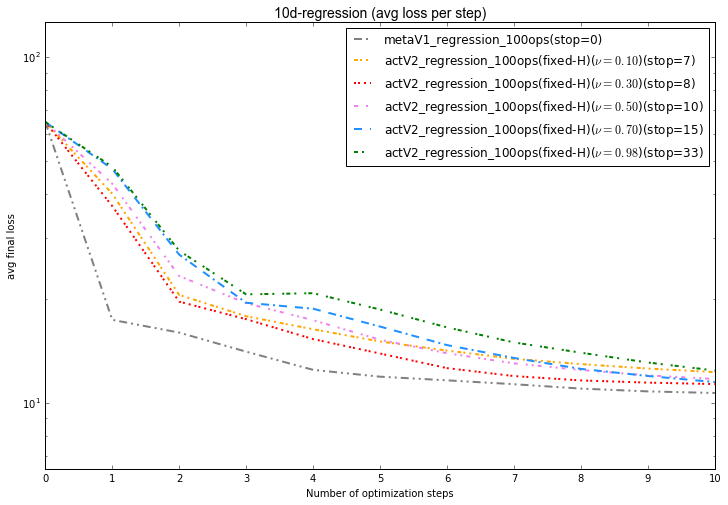

In [5]:
# new_exp_only = [new_experiments[5], new_experiments[6], new_experiments[7]] 
best_val_runs, lowest_value = plot_loss_over_tsteps(new_experiments, do_show=True, 
                                              do_save=False, 
                                              plot_best=False,
                                              fig_name="10_dim_compare_metaV1_actV1_10steps", 
                                              loss_type="loss",
                                              min_step=0,
                                              max_step=10,
                                              sort_exper="10d-regression",
                                              log_scale=True,
                                              with_stddev=False,
                                              runID=None)

In [ ]:
plot_qt_probs(experiments[1], data_set="train", show=True, plot_prior=False, save=True)

In [ ]:
# exp_error_curves = [experiments[0],  experiments[3]]
for exp, mdl in zip(experiments, models):
    print(mdl.name)
    loss_plot(exp, loss_type="loss", save=False, validation=True, show=True)


In [ ]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [ ]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [2]:
val_funcs = RegressionFunction(n_funcs=20000, n_samples=10, stddev=1.0, 
                             x_dim=10, use_cuda=True)
with open("data/val_funcs_20000_10_1.0_10.dll", 'wb') as f:
     dill.dump(val_funcs, f)
print("Success")

Success


In [4]:
"""
    Create some new validation functions
"""
num_of_val_funcs = 20000
val_funcs = L2LQuadratic(batch_size=num_of_val_funcs, num_dims=10, stddev=0.01, use_cuda=True)
print("Ready")

Ready


In [87]:
with open("data/val_funcs_20000_10_1.0_10.dll", 'rb') as f:
    val_funcs = dill.load(f)
print("Success")

Success


In [6]:
test_funcs = RegressionFunction(n_funcs=20000, n_samples=10, stddev=1., 
                             x_dim=10, use_cuda=True, calc_true_params=False)
with open("data/test_funcs_20000_10_1.0_10.dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")

Ready


In [4]:
with open("data/test_funcs_20000_10_1.0_10.dll", 'rb') as f:
     test_funcs = dill.load(f)
print("Ready")

Ready


In [5]:
print(len(new_experiments))
exp_idx = 3
max_steps = 100
new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].config.qt_threshold = 0.95
new_experiments[exp_idx].reset_val_stats()
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=test_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5, save_model=False, save_qt_prob_funcs=True, save_run="test20000")

INFO - ---------------------------------------------------------------------------------------
INFO - INFO - Epoch 400: Validating model metaV3_regression_100ops with 20000 functions


4
Validating model metaV3_regression_100ops with q-prob 0.980


INFO - INFO - Epoch 400, elapsed time 17.62 seconds: 
INFO - INFO - Epoch 400: Final validation stats: total-step-losses / final-step loss / final-true_min: 1.054e+03/9.389/0.1997
INFO - INFO - Epoch 400: Final step losses: [ 64.786  17.288  15.846  13.539  12.079  11.821  11.4    11.041  10.852
  10.673  10.584  10.455  10.348  10.276  10.211  10.149  10.097  10.055
  10.011   9.974   9.942   9.913   9.884   9.858   9.836   9.814   9.794
   9.775   9.757   9.741   9.726   9.711   9.696   9.684   9.671   9.659
   9.648   9.638   9.628   9.618   9.609   9.6     9.592   9.584   9.576
   9.569   9.562   9.555   9.549   9.542   9.536   9.531   9.525   9.52
   9.515   9.51    9.505   9.5     9.496   9.492   9.487   9.483   9.479
   9.475   9.472   9.468   9.464   9.461   9.458   9.455   9.452   9.449
   9.446   9.443   9.44    9.437   9.435   9.432   9.43    9.427   9.425
   9.423   9.421   9.418   9.416   9.414   9.412   9.41    9.408   9.406
   9.405   9.403   9.401   9.4     9.398   9.39

INFO - Successfully saved experimental details to logs/run_20170706_09_48_03_metaV3_80ep_100ops_lr5e05_adam/exp_statistics_test20000.dll


In [4]:
del new_experiments
new_experiments = []

for exper in expers_to_load:
    if exper[0]:
        new_experiments.append(get_experiment(path_to_exp=exper[1] + "/" + "exp_statistics_test20000.dll",
                                              full_path=True))
print("Ready")

Ready


In [16]:
del new_experiments[0]


('Key ', 100)
INFO - Successfully saved fig logs/run_20170708_11_19_46_actV1_20ep_21ops_retrain_lr2e05_adam/qt_T_dist_val_actV1_20ep_21ops_retrain.png


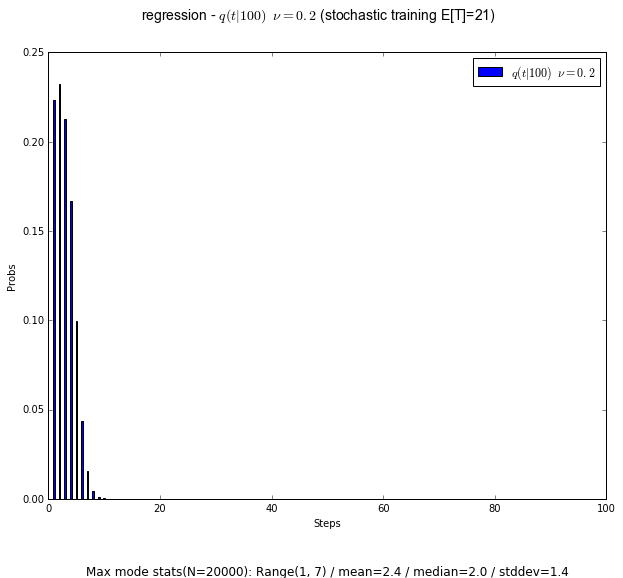

In [9]:
plot_qt_probs(new_experiments[3], data_set="val", save=True, show=True, 
              plot_prior=False, height=20, width=20, add_info=True)

In [122]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

('key ', 100)


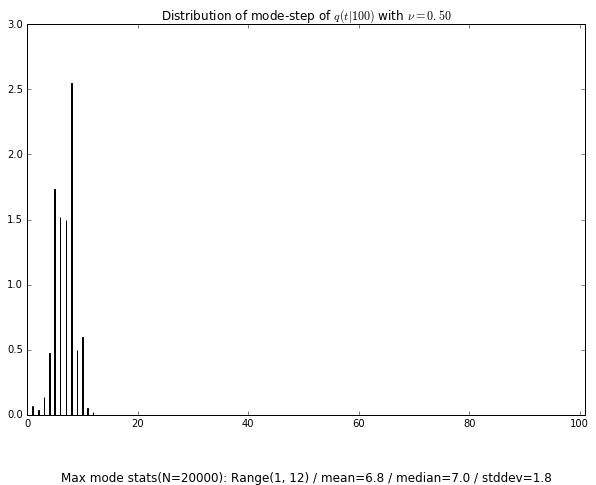

In [23]:
plot_qt_mode_hist(new_experiments[1], do_save=False, do_show=True, add_info=True)

In [ ]:
def compute_yt(W, x):
    return torch.transpose(torch.mm(W ,x.unsqueeze(1)), 1,0)

def compute_params(W, y, cuda=False):
    
    A_plus = np.linalg.pinv(W.data.cpu().numpy())
    y = y.data.cpu().numpy()
    params = np.squeeze(np.dot(A_plus, y))
    params = Variable(torch.from_numpy(params).float().unsqueeze(0))
    if cuda:
        params = params.cuda()
    return params
    


Run with key 100
INFO - Successfully saved fig logs/run_20170708_11_19_46_actV1_20ep_21ops_retrain_lr2e05_adam/qt_detailed_stats_actV1_20ep_21ops_retrain.png


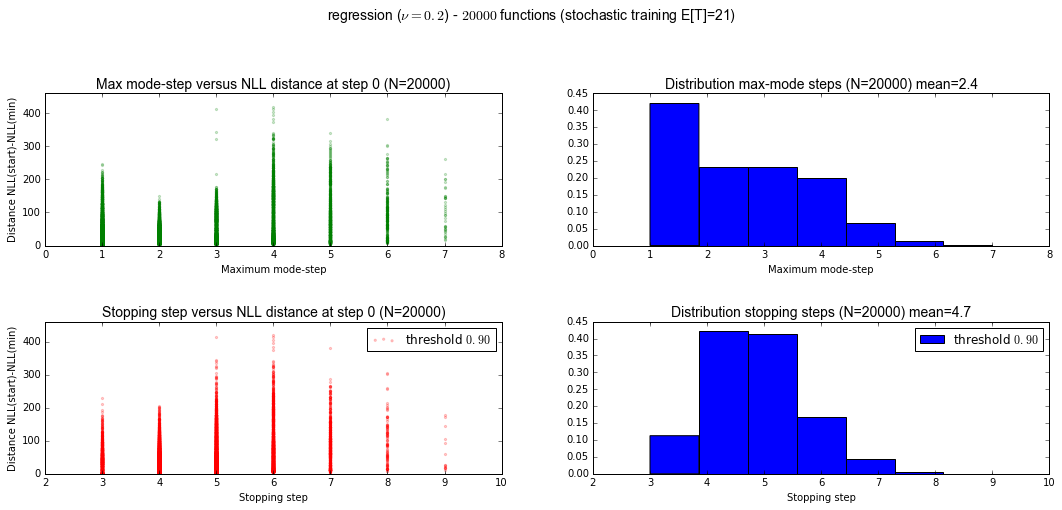

In [10]:
plot_qt_detailed_stats(new_experiments[3], test_funcs, do_save=True, do_show=True, threshold=0.90)

In [ ]:
 # 
plot_kl_div_parts(new_experiments[1], save=False, show=True, final_terms=False, log_qt=True, plot_prior=True,
                 fig_name="kl_parts_without_tanh")

In [9]:
# stops = np.cumsum(q_probs, 1)[:, -2] > threshold
q_probs = new_experiments[5].val_stats["qt_funcs"][100]
threshold = 0.95
stops = np.cumsum(q_probs, 1)[:, -2] > threshold

In [11]:
stops[0:10]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)